> ไฟล์ Python Notebook สำหรับหนังสือ "การเรียนรู้ของเครื่องสำหรับเคมีควอนตัม" โดย รังสิมันต์ เกษแก้ว

> This is a Python notebook for "Machine Learning for Quantum Chemistry" book by Rangsiman Ketkaew

## ฝึกสอนโมเดล Neural Network สำหรับใช้เป็น Force Field ในการทำนายพลังงานและแรง (Machine Learning Force Field)

In [1]:
import numpy as np
import ase
from ase.calculators.lj import LennardJones
import matplotlib.pyplot as plt
from dscribe.descriptors import SOAP

### 1. สร้าง Dataset

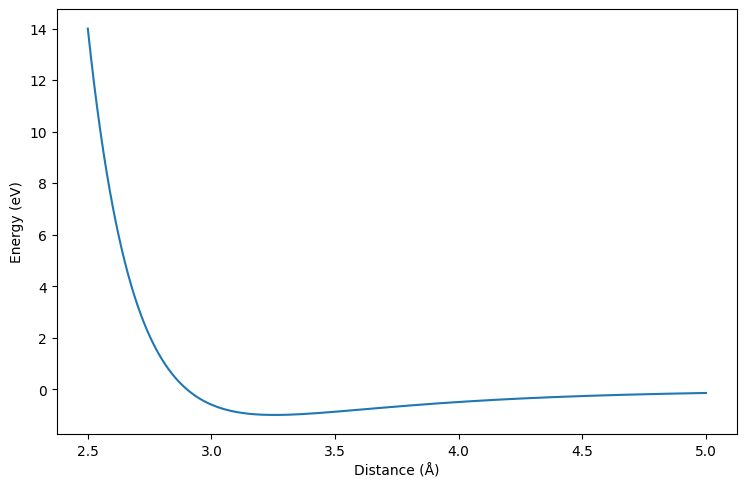

In [2]:
# Setting up the SOAP descriptor
soap = SOAP(
    species=["H"],
    periodic=False,
    rcut=5.0,
    sigma=0.5,
    nmax=3,
    lmax=0,
)

# Generate dataset of Lennard-Jones energies and forces
n_samples = 200
traj = []
n_atoms = 2
energies = np.zeros(n_samples)
forces = np.zeros((n_samples, n_atoms, 3))
r = np.linspace(2.5, 5.0, n_samples)
for i, d in enumerate(r):
    a = ase.Atoms('HH', positions = [[-0.5 * d, 0, 0], [0.5 * d, 0, 0]])
    a.set_calculator(LennardJones(epsilon=1.0 , sigma=2.9))
    traj.append(a)
    energies[i] = a.get_total_energy()
    forces[i, :, :] = a.get_forces()
	
# Plot the energies to validate them
fig, ax = plt.subplots(figsize=(8, 5))
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)
line, = ax.plot(r, energies)
plt.xlabel("Distance (Å)")
plt.ylabel("Energy (eV)")
plt.show()

# Create the SOAP desciptors and their derivatives for all samples. One center
# is chosen to be directly between the atoms.
derivatives, descriptors = soap.derivatives(
    traj,
    positions=[[[0, 0, 0]]] * len(r),
    method="analytical"
)

# Save to disk for later training
np.save("r.npy", r)
np.save("E.npy", energies)
np.save("D.npy", descriptors)
np.save("dD_dr.npy", derivatives)
np.save("F.npy", forces)

### 2. นำเข้าชุดข้อมูลและเตรียม Input สำหรับฝึกสอนโมเดล

In [3]:
import torch
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
torch.manual_seed(7)

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load the dataset
D_numpy = np.load("D.npy")[:, 0, :]  # We only have one SOAP center 
n_samples, n_features = D_numpy.shape
E_numpy = np.array([np.load("E.npy")]).T
F_numpy = np.load("F.npy")
dD_dr_numpy = np.load("dD_dr.npy")[:, 0, :, :, : ]  # We only have one SOAP center 
r_numpy = np.load("r.npy")

# Select equally spaced points for training
n_train = 30
idx = np.linspace(0, len(r_numpy) - 1, n_train).astype(int)
D_train_full = D_numpy[idx]
E_train_full = E_numpy[idx]
F_train_full = F_numpy[idx]
r_train_full = r_numpy[idx]
dD_dr_train_full = dD_dr_numpy[idx]

# Standardize input for improved learning. Fit is done only on training data,
# scaling is applied to both descriptors and their derivatives on training and
# test sets.
scaler = StandardScaler().fit(D_train_full)
D_train_full = scaler.transform(D_train_full)
D_whole = scaler.transform(D_numpy)
dD_dr_whole = dD_dr_numpy / scaler.scale_[None, None, None, :]
dD_dr_train_full = dD_dr_train_full / scaler.scale_[None, None, None, :]

# Calculate the variance of energy and force values for the training set. These
# are used to balance their contribution to the MSE loss
var_energy_train = E_train_full.var()
var_force_train = F_train_full.var()

# Subselect 20% of validation points for early stopping.
D_train, D_valid, E_train, E_valid, F_train, F_valid, dD_dr_train, dD_dr_valid = train_test_split(
    D_train_full,
    E_train_full,
    F_train_full,
    dD_dr_train_full,
    test_size=0.2,
    random_state=7,
)

# Create tensors for pytorch
D_whole = torch.Tensor(D_whole)
D_train = torch.Tensor(D_train)
D_valid = torch.Tensor(D_valid)
E_train = torch.Tensor(E_train)
E_valid = torch.Tensor(E_valid)
F_train = torch.Tensor(F_train)
F_valid = torch.Tensor(F_valid)
dD_dr_train = torch.Tensor(dD_dr_train)
dD_dr_valid = torch.Tensor(dD_dr_valid)

### 3. สร้างโมเดลและกำหนด Loss Function

In [5]:
class FFNet(torch.nn.Module):
    """A simple feed-forward network with one hidden layer, randomly
    initialized weights, sigmoid activation and a linear output layer.
    """
    def __init__(self, n_features, n_hidden, n_out):
        super(FFNet, self).__init__()
        self.linear1 = torch.nn.Linear(n_features, n_hidden)
        torch.nn.init.normal_(self.linear1.weight, mean=0, std=1.0)
        self.sigmoid = torch.nn.Sigmoid()
        self.linear2 = torch.nn.Linear(n_hidden, n_out)
        torch.nn.init.normal_(self.linear2.weight, mean=0, std=1.0)

    def forward(self, x):
        x = self.linear1(x)
        x = self.sigmoid(x)
        x = self.linear2(x)

        return x


def energy_force_loss(E_pred, E_train, F_pred, F_train):
    """Custom loss function that targets both energies and forces.
    """
    energy_loss = torch.mean((E_pred - E_train)**2) / var_energy_train
    force_loss = torch.mean((F_pred - F_train)**2) / var_force_train
    return energy_loss + force_loss

# Initialize model
model = FFNet(n_features, n_hidden=5, n_out=1)

# The Adam optimizer is used for training the model parameters
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

### 4. ฝึกสอนโมเดล (Training)

In [6]:
# Train!
n_max_epochs = 5000
batch_size = 2
patience = 20
i_worse = 0
old_valid_loss = float("Inf")
best_valid_loss = float("Inf")

# We explicitly require that the gradients should be calculated for the input
# variables. PyTorch will not do this by default as it is typically not needed.
D_valid.requires_grad = True

# Epochs
for i_epoch in range(n_max_epochs):

    # Batches
    permutation = torch.randperm(D_train.size()[0])
    for i in range(0, D_train.size()[0], batch_size):

        indices = permutation[i:i+batch_size]
        D_train_batch, E_train_batch = D_train[indices], E_train[indices]
        D_train_batch.requires_grad = True
        F_train_batch, dD_dr_train_batch = F_train[indices], dD_dr_train[indices]

        # Forward pass: Predict energies from the descriptor input
        E_train_pred_batch = model(D_train_batch)

        # Get derivatives of model output with respect to input variables. The
        # torch.autograd.grad-function can be used for this, as it returns the
        # gradients of the input with respect to outputs. It is very important
        # to set the create_graph=True in this case. Without it the derivatives
        # of the NN parameters with respect to the loss from the force error
        # will not be populated (=the force error will not affect the
        # training), but the model will still run fine without errors.
        df_dD_train_batch = torch.autograd.grad(
            outputs=E_train_pred_batch,
            inputs=D_train_batch,
            grad_outputs=torch.ones_like(E_train_pred_batch),
            create_graph=True,
        )[0]

        # Get derivatives of input variables (=descriptor) with respect to atom
        # positions = forces
        F_train_pred_batch = -torch.einsum('ijkl,il->ijk', dD_dr_train_batch, df_dD_train_batch)

        # Zero gradients, perform a backward pass, and update the weights.
        # D_train_batch.grad.data.zero_()
        optimizer.zero_grad()
        loss = energy_force_loss(E_train_pred_batch, E_train_batch, F_train_pred_batch, F_train_batch)
        loss.backward()
        optimizer.step()
            
    # Check early stopping criterion and save best model
    E_valid_pred = model(D_valid)
    df_dD_valid = torch.autograd.grad(
        outputs=E_valid_pred,
        inputs=D_valid,
        grad_outputs=torch.ones_like(E_valid_pred),
    )[0]
    F_valid_pred = -torch.einsum('ijkl,il->ijk', dD_dr_valid, df_dD_valid)
    valid_loss = energy_force_loss(E_valid_pred, E_valid, F_valid_pred, F_valid)
    if valid_loss < best_valid_loss:
        # print("Saving at epoch {}".format(i_epoch))
        torch.save(model.state_dict(), "best_model.pt")
        best_valid_loss = valid_loss
    if valid_loss >= old_valid_loss:
        i_worse += 1
    else:
        i_worse = 0
    if i_worse > patience:
        print("Early stopping at epoch {}".format(i_epoch))
        break
    old_valid_loss = valid_loss

    if i_epoch % 500 == 0:
        print("  Finished epoch: {} with loss: {}".format(i_epoch, loss.item()))

  Finished epoch: 0 with loss: 21.220672607421875
  Finished epoch: 500 with loss: 0.0004732480738312006
  Finished epoch: 1000 with loss: 0.01046457514166832
  Finished epoch: 1500 with loss: 4.018305116915144e-05
  Finished epoch: 2000 with loss: 8.0366779002361e-05
  Finished epoch: 2500 with loss: 1.7976299204747193e-05
  Finished epoch: 3000 with loss: 0.00024088378995656967
  Finished epoch: 3500 with loss: 0.0008821815135888755
  Finished epoch: 4000 with loss: 8.457103103864938e-05
  Finished epoch: 4500 with loss: 5.806452827528119e-05


### 5. วิเคราะห์โมเดล

In [8]:
# Way to tell pytorch that we are entering the evaluation phase
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

FFNet(
  (linear1): Linear(in_features=6, out_features=5, bias=True)
  (sigmoid): Sigmoid()
  (linear2): Linear(in_features=5, out_features=1, bias=True)
)

In [9]:
# Calculate energies and force for the entire range
E_whole = torch.Tensor(E_numpy)
F_whole = torch.Tensor(F_numpy)
dD_dr_whole = torch.Tensor(dD_dr_whole)
r_whole = r_numpy
D_whole.requires_grad = True
E_whole_pred = model(D_whole)
df_dD_whole = torch.autograd.grad(
    outputs=E_whole_pred,
    inputs=D_whole,
    grad_outputs=torch.ones_like(E_whole_pred),
)[0]

F_whole_pred = -torch.einsum('ijkl,il->ijk', dD_dr_whole, df_dD_whole)

In [10]:
F_whole_pred

tensor([[[-9.4200e+01, -0.0000e+00, -0.0000e+00],
         [ 9.4200e+01, -0.0000e+00, -0.0000e+00]],

        [[-9.6559e+01, -0.0000e+00, -0.0000e+00],
         [ 9.6559e+01, -0.0000e+00, -0.0000e+00]],

        [[-9.1401e+01, -0.0000e+00, -0.0000e+00],
         [ 9.1401e+01, -0.0000e+00, -0.0000e+00]],

        ...,

        [[ 3.4931e-02, -0.0000e+00, -0.0000e+00],
         [-3.4931e-02, -0.0000e+00, -0.0000e+00]],

        [[ 1.5592e-02, -0.0000e+00, -0.0000e+00],
         [-1.5592e-02, -0.0000e+00, -0.0000e+00]],

        [[-3.6762e-03, -0.0000e+00, -0.0000e+00],
         [ 3.6762e-03, -0.0000e+00, -0.0000e+00]]])

### 6. พลอตกราฟพลังงานและแรงที่ทำนายได้ และกราฟการฝึกสอน

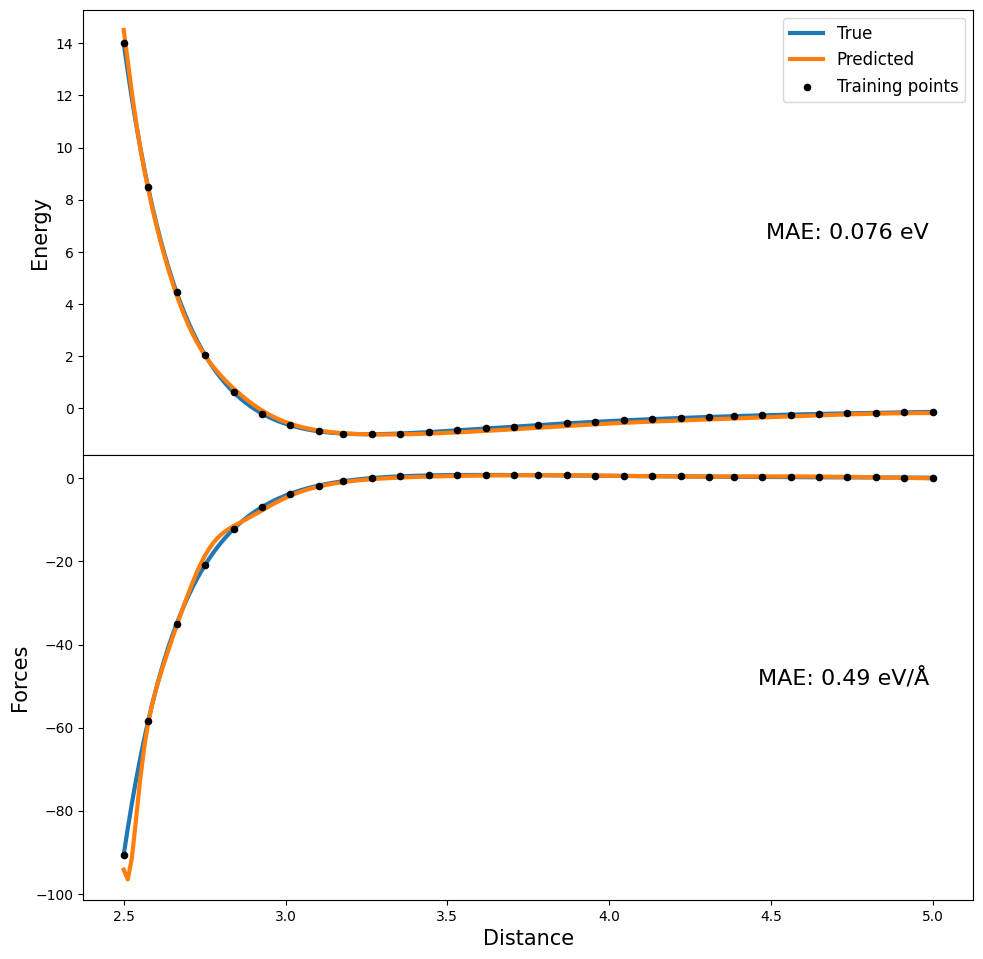

In [11]:
# Plot energies for the whole range
E_whole_pred = E_whole_pred.detach().numpy()
E_whole = E_whole.detach().numpy()
order = np.argsort(r_whole)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10))
ax1.plot(r_whole[order], E_whole[order], label="True", linewidth=3, linestyle="-")
ax1.plot(r_whole[order], E_whole_pred[order], label="Predicted", linewidth=3, linestyle="-")
ax1.set_ylabel('Energy', size=15)
mae_energy = mean_absolute_error(E_whole_pred, E_whole)
ax1.text(0.95, 0.5, "MAE: {:.2} eV".format(mae_energy), size=16, horizontalalignment='right', verticalalignment='center', transform=ax1.transAxes)

# Plot forces for whole range
F_x_whole_pred = F_whole_pred.detach().numpy()[order, 0, 0]
F_x_whole = F_whole[:, 0, 0][order]
ax2.plot(r_whole[order], F_x_whole, label="True", linewidth=3, linestyle="-")
ax2.plot(r_whole[order], F_x_whole_pred, label="Predicted", linewidth=3, linestyle="-")
ax2.set_xlabel('Distance', size=15)
ax2.set_ylabel('Forces', size=15)
mae_force = mean_absolute_error(F_x_whole_pred, F_x_whole)
ax2.text(0.95, 0.5, "MAE: {:.2} eV/Å".format(mae_force), size=16, horizontalalignment='right', verticalalignment='center', transform=ax2.transAxes)

# Plot training points
F_x_train_full = F_train_full[:, 0, 0]
ax1.scatter(r_train_full, E_train_full, marker="o", color="k", s=20, label="Training points", zorder=3)
ax2.scatter(r_train_full, F_x_train_full, marker="o", color="k", s=20, label="Training points", zorder=3)

# Show plot
ax1.legend(fontsize=12)
plt.subplots_adjust(left=0.08, right=0.97, top=0.97, bottom=0.08, hspace=0)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fc3d2631-9178-4bf3-9db3-87923c482dce' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>